In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

#### Data Preprocessing


In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALID_EXTS = [".jpg", ".jpeg", ".png", ".bmp"]

# Path
base_dir = r"C:\Users\nacha\Downloads\archive (2)\marine-animals-dataset\versions\1"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')


def load_images_from_directory(directory, class_indices=None, augment=False):
    images = []
    labels = []
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    
    
    if class_indices is None:
        class_indices = {cls_name: idx for idx, cls_name in enumerate(classes)}
    
    for cls_name in classes:
        cls_folder = os.path.join(directory, cls_name)
        for fname in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, fname)

          
            if not any(fname.lower().endswith(ext) for ext in VALID_EXTS):
                continue

           
            img = cv2.imread(img_path)
            if img is None:  
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype("float32") / 255.0  
            
            if augment:
                img = apply_augmentations(img)
            
            images.append(img)
            labels.append(class_indices[cls_name])
    
    return np.array(images), np.array(labels), class_indices


def apply_augmentations(image):
    h, w = image.shape[:2]
    
    
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
    
  
    angle = np.random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    
   
    scale = np.random.uniform(0.8, 1.2)
    new_size = int(h * scale), int(w * scale)
    zoomed = cv2.resize(image, new_size)
    if scale < 1:  
        pad_h = (h - new_size[0]) // 2
        pad_w = (w - new_size[1]) // 2
        image = np.pad(zoomed, ((pad_h, h - new_size[0] - pad_h), (pad_w, w - new_size[1] - pad_w), (0,0)), mode="reflect")
    else:  
        start_h = (new_size[0] - h) // 2
        start_w = (new_size[1] - w) // 2
        image = zoomed[start_h:start_h+h, start_w:start_w+w]
    
    
    max_shift = 0.2
    tx = np.random.uniform(-max_shift, max_shift) * w
    ty = np.random.uniform(-max_shift, max_shift) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    return image


X_train, y_train, class_indices = load_images_from_directory(train_dir, augment=True)
X_valid, y_valid, _ = load_images_from_directory(valid_dir, class_indices=class_indices)
X_test,  y_test,  _ = load_images_from_directory(test_dir,  class_indices=class_indices)


y_train = to_categorical(y_train, num_classes=len(class_indices))
y_valid = to_categorical(y_valid, num_classes=len(class_indices))
y_test  = to_categorical(y_test,  num_classes=len(class_indices))


X_train, y_train = shuffle(X_train, y_train, random_state=42)
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:",  X_test.shape,  y_test.shape)
print("Class indices:", class_indices)

Found 1241 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


#### Feature Extraction (Using Pretrained Model)

In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

def extract_features_from_array(X, y, batch_size=32):
    features = []
    labels = []
    n_samples = X.shape[0]

  
    for i in range(0, n_samples, batch_size):
        batch_x = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        batch_features = model.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)

    return np.vstack(features), np.vstack(labels)


train_features, train_labels = extract_features_from_array(X_train, y_train)
valid_features, valid_labels = extract_features_from_array(X_valid, y_valid)
test_features, test_labels   = extract_features_from_array(X_test,  y_test)


print(f"Train Features Shape: {train_features.shape}")
print(f"Validation Features Shape: {valid_features.shape}")
print(f"Test Features Shape: {test_features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 

#### Dimensionality Reduction

In [ ]:

def manual_pca(X_train, X_valid, X_test, n_components=50):
    
  
    mean_vector = np.mean(X_train, axis=0)
    X_train_centered = X_train - mean_vector
    X_valid_centered = X_valid - mean_vector
    X_test_centered  = X_test  - mean_vector

    
    cov_matrix = np.cov(X_train_centered, rowvar=False)

   
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)  

    
    sorted_idx = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, sorted_idx]
    eig_vals = eig_vals[sorted_idx]

   
    principal_components = eig_vecs[:, :n_components]

   
    X_train_pca = np.dot(X_train_centered, principal_components)
    X_valid_pca = np.dot(X_valid_centered, principal_components)
    X_test_pca  = np.dot(X_test_centered, principal_components)

    return X_train_pca, X_valid_pca, X_test_pca, eig_vals[:n_components], principal_components


train_features_pca, valid_features_pca, test_features_pca, eig_vals, eig_vecs = manual_pca(
    train_features, valid_features, test_features, n_components=50
)


print(f"Train Features (PCA) Shape: {train_features_pca.shape}")
print(f"Validation Features (PCA) Shape: {valid_features_pca.shape}")
print(f"Test Features (PCA) Shape: {test_features_pca.shape}")

Train Features (PCA) Shape: (1241, 50)
Validation Features (PCA) Shape: (250, 50)
Test Features (PCA) Shape: (100, 50)


#### Train the KNN Model

In [ ]:

def euclidean_distance(a, b):
    a_squared = np.sum(a**2, axis=1).reshape(-1,1)
    b_squared = np.sum(b**2, axis=1).reshape(1,-1)
    ab = np.dot(a, b.T)
    return np.sqrt(a_squared + b_squared - 2*ab)


def knn_predict(train_X, train_y, test_X, k=5):
    dists = euclidean_distance(test_X, train_X)
    num_test = test_X.shape[0]
    y_pred = np.zeros(num_test, dtype=int)

    for i in range(num_test):
        nearest_idx = np.argsort(dists[i])[:k]
        nearest_labels = train_y[nearest_idx]
        nearest_dists  = dists[i][nearest_idx]
        weights = 1 / (nearest_dists + 1e-8)
        class_votes = {}
        for label, w in zip(nearest_labels, weights):
            class_votes[label] = class_votes.get(label, 0) + w
        y_pred[i] = max(class_votes, key=class_votes.get)
    return y_pred


def classification_report_format(y_true, y_pred):
    classes = np.unique(y_true)
    precision_list, recall_list, f1_list, support_list = [], [], [], []

   
    print("              precision    recall  f1-score   support")
    
    for cls in classes:
        tp = np.sum((y_pred==cls) & (y_true==cls))
        fp = np.sum((y_pred==cls) & (y_true!=cls))
        fn = np.sum((y_pred!=cls) & (y_true==cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score  = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
        support   = np.sum(y_true==cls)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)
        support_list.append(support)

        print(f"{cls:<14}{precision:>9.2f}{recall:>9.2f}{f1_score:>9.2f}{support:>9}")

   
    accuracy = np.mean(y_pred==y_true)
    support_total = np.sum(support_list)
    macro_avg = (np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), support_total)
    weighted_avg = (
        np.average(precision_list, weights=support_list),
        np.average(recall_list, weights=support_list),
        np.average(f1_list, weights=support_list),
        support_total
    )

    print(f"\n   accuracy                           {accuracy:>5.2f}{support_total:>9}")
    print(f"  macro avg       {macro_avg[0]:>5.2f}{macro_avg[1]:>9.2f}{macro_avg[2]:>9.2f}{macro_avg[3]:>9}")
    print(f"weighted avg       {weighted_avg[0]:>5.2f}{weighted_avg[1]:>9.2f}{weighted_avg[2]:>9.2f}{weighted_avg[3]:>9}")


train_y_int = np.argmax(train_labels, axis=1)
valid_y_int = np.argmax(valid_labels, axis=1)
test_y_int  = np.argmax(test_labels, axis=1)


valid_pred = knn_predict(train_features_pca, train_y_int, valid_features_pca, k=5)
test_pred  = knn_predict(train_features_pca, train_y_int, test_features_pca,  k=5)


valid_accuracy = np.mean(valid_pred == valid_y_int)
test_accuracy  = np.mean(test_pred  == test_y_int)

print(f"Validation Accuracy: {valid_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}\n")


classification_report_format(test_y_int, test_pred)

Validation Accuracy: 0.592
Test Accuracy: 0.68
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.58      0.35      0.44        20
           2       0.69      0.90      0.78        20
           3       0.58      0.55      0.56        20
           4       0.68      0.65      0.67        20

    accuracy                           0.68       100
   macro avg       0.67      0.68      0.66       100
weighted avg       0.67      0.68      0.66       100



#### Tune KNN Hyperparameters 

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

best_score = -1
best_params = None

for n_neighbors in param_grid['n_neighbors']:
    for weights in param_grid['weights']:
        for metric in param_grid['metric']:
            scores = []
            for fold in range(5):
                train_idx = [i for i in range(len(train_features_pca)) if i % 5 != fold]
                val_idx = [i for i in range(len(train_features_pca)) if i % 5 == fold]
                
                X_fold_train = train_features_pca[train_idx]
                y_fold_train = np.argmax(train_labels, axis=1)[train_idx]
                X_fold_val = train_features_pca[val_idx]
                y_fold_val = np.argmax(train_labels, axis=1)[val_idx]
                
                y_pred = knn_predict(X_fold_train, y_fold_train, X_fold_val, n_neighbors, weights, metric)
                score = accuracy_score(y_fold_val, y_pred)
                scores.append(score)
            
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

print("Best Hyperparameters:", best_params)

valid_pred_tuned = knn_predict(train_features_pca, np.argmax(train_labels, axis=1), valid_features_pca, best_params['n_neighbors'], best_params['weights'], best_params['metric'])
valid_accuracy_tuned = accuracy_score(np.argmax(valid_labels, axis=1), valid_pred_tuned)
print(f"Tuned Validation Accuracy: {valid_accuracy_tuned}")

test_pred_tuned = knn_predict(train_features_pca, np.argmax(train_labels, axis=1), test_features_pca, best_params['n_neighbors'], best_params['weights'], best_params['metric'])
test_accuracy_tuned = accuracy_score(np.argmax(test_labels, axis=1), test_pred_tuned)
print(f"Tuned Test Accuracy: {test_accuracy_tuned}")

print(f"Tuned Classification Report for Test Set:\n{classification_report(np.argmax(test_labels, axis=1), test_pred_tuned)}")

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Tuned Validation Accuracy: 0.576
Tuned Test Accuracy: 0.72
Tuned Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.82      0.45      0.58        20
           2       0.70      0.80      0.74        20
           3       0.56      0.70      0.62        20
           4       0.82      0.70      0.76        20

    accuracy                           0.72       100
   macro avg       0.74      0.72      0.71       100
weighted avg       0.74      0.72      0.71       100



Tuned Confusion Matrix:
[[19  0  1  0  0]
 [ 1  9  2  6  2]
 [ 1  0 16  2  1]
 [ 2  1  3 14  0]
 [ 1  1  1  3 14]]


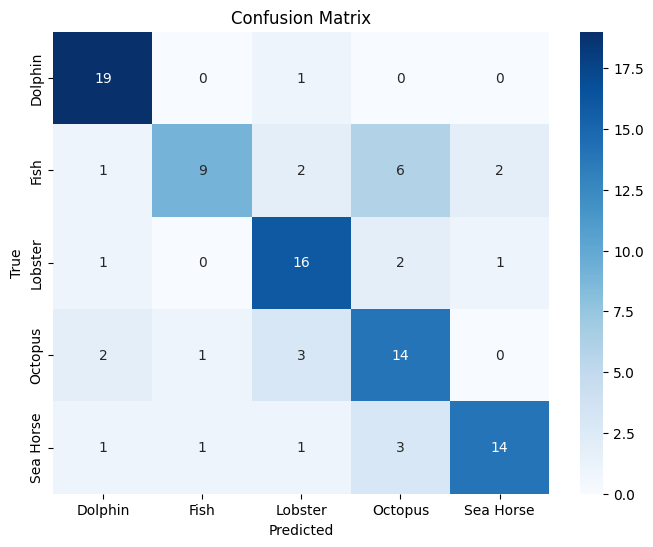

In [ ]:

def manual_confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_idx[true_label]
        pred_idx = class_to_idx[pred_label]
        conf_matrix[true_idx][pred_idx] += 1
    
    return conf_matrix, classes


def manual_heatmap(conf_matrix, class_names, title="Confusion Matrix"):
    n_classes = len(class_names)
    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    
    def blues_colormap(value, max_value):
        intensity = 1 - (value / max_value) * 0.7  
        return (intensity, intensity) 
    
    max_value = np.max(conf_matrix)
    
    
    for i in range(n_classes):
        for j in range(n_classes):
            color = blues_colormap(conf_matrix[i, j], max_value)
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='white')
            ax.add_patch(rect)
            
           
            ax.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), 
                   ha='center', va='center', fontsize=12,
                   color='white' if conf_matrix[i, j] > max_value/2 else 'black')
    
    ax.set_xticks(np.arange(n_classes) + 0.5)
    ax.set_yticks(np.arange(n_classes) + 0.5)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()


conf_matrix_tuned, classes = manual_confusion_matrix(test_y, test_pred)
print(f"Tuned Confusion Matrix:\n{conf_matrix_tuned}")


class_names = [str(cls) for cls in classes]


manual_heatmap(conf_matrix_tuned, class_names, title='Confusion Matrix - Tuned KNN Model')

In [ ]:
def manual_classification_report(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    
    precision_list = []
    recall_list = []
    f1_list = []
    support_list = []
    
   
    result = "              precision    recall  f1-score   support\n\n"
    
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        support = np.sum(y_true == cls)
        
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        support_list.append(support)
        
       
        result += f"{cls:>14} {precision:>9.2f} {recall:>9.2f} {f1:>9.2f} {support:>9}\n"
    
    
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    
  
    macro_precision = np.mean(precision_list)
    macro_recall = np.mean(recall_list)
    macro_f1 = np.mean(f1_list)
    
   
    weighted_precision = np.average(precision_list, weights=support_list)
    weighted_recall = np.average(recall_list, weights=support_list)
    weighted_f1 = np.average(f1_list, weights=support_list)
    total_support = np.sum(support_list)
    
   
    result += f"\n{'accuracy':>14} {'':>9} {'':>9} {accuracy:>9.2f} {total_support:>9}\n"
    result += f"{'macro avg':>14} {macro_precision:>9.2f} {macro_recall:>9.2f} {macro_f1:>9.2f} {total_support:>9}\n"
    result += f"{'weighted avg':>14} {weighted_precision:>9.2f} {weighted_recall:>9.2f} {weighted_f1:>9.2f} {total_support:>9}\n"
    
    return result


def manual_confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
   
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_idx[true_label]
        pred_idx = class_to_idx[pred_label]
        conf_matrix[true_idx][pred_idx] += 1
    
    return conf_matrix


print("Classification Report (Validation Set):")
print(manual_classification_report(valid_y, valid_pred))


print("Classification Report (Test Set):")
print(manual_classification_report(test_y, test_pred))


conf_matrix = manual_confusion_matrix(test_y, test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.94      0.80        50
           1       0.66      0.38      0.48        50
           2       0.50      0.64      0.56        50
           3       0.44      0.36      0.40        50
           4       0.57      0.56      0.57        50

    accuracy                           0.58       250
   macro avg       0.57      0.58      0.56       250
weighted avg       0.57      0.58      0.56       250

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.82      0.45      0.58        20
           2       0.70      0.80      0.74        20
           3       0.56      0.70      0.62        20
           4       0.82      0.70      0.76        20

    accuracy                           0.72       100
   macro avg       0.74      0.72      0.71       100
wei

#### PCA experiment

In [ ]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)
test_features_scaled = scaler.transform(test_features)

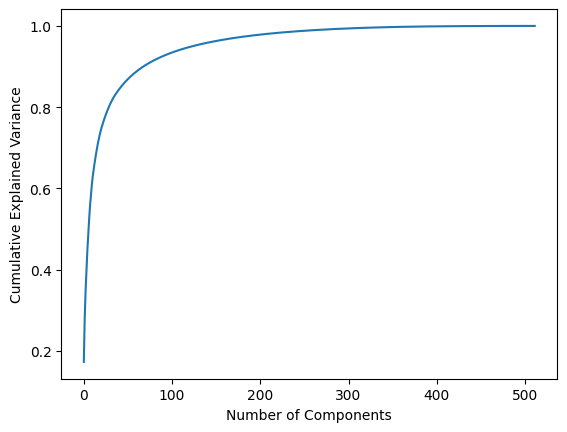

In [ ]:

def manual_pca_explained_variance(X):
    X_centered = X - np.mean(X, axis=0)
    
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    return explained_variance_ratio


explained_variance_ratio = manual_pca_explained_variance(train_features)


cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.8, label='95% Variance')
plt.legend()
plt.show()




In [ ]:
train_features_flat = train_features.reshape(train_features.shape[0], -1)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_flat)
valid_features_scaled = scaler.transform(valid_features_flat)
test_features_scaled = scaler.transform(test_features_flat)

In [ ]:
pca = manual_pca(n_components=250)
train_features_pca = pca.fit_transform(train_features_scaled)
valid_features_pca = pca.transform(valid_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by 250 components: {explained_variance:.2f}")

Explained Variance by 250 components: 0.94


In [ ]:
class ManualKNeighborsClassifier:
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        y_pred = []
        for test_sample in X:
            
            distances = np.sqrt(np.sum((self.X_train - test_sample) ** 2, axis=1))
            neighbors_idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbors_idx]
            
            if self.weights == 'uniform':
                
                counts = np.bincount(neighbor_labels)
                y_pred.append(np.argmax(counts))
            elif self.weights == 'distance':
              
                neighbor_dists = distances[neighbors_idx]
                weights = 1 / (neighbor_dists + 1e-8)  
                
                weighted_votes = {}
                for label, weight in zip(neighbor_labels, weights):
                    weighted_votes[label] = weighted_votes.get(label, 0) + weight
                
                y_pred.append(max(weighted_votes, key=weighted_votes.get))
            else:
                raise ValueError("Invalid weight type")
        
        return np.array(y_pred)


def manual_accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


print(f"Baseline Validation Accuracy: {valid_accuracy:.4f}")
print(f"Baseline Test Accuracy: {test_accuracy:.4f}")


Baseline Validation Accuracy: 0.5280
Baseline Test Accuracy: 0.6900


In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

best_score = -1
best_params = None

for n_neighbors in param_grid['n_neighbors']:
    for weights in param_grid['weights']:
        for metric in param_grid['metric']:
            scores = []
            for fold in range(5):
                train_idx = [i for i in range(len(train_features_pca)) if i % 5 != fold]
                val_idx = [i for i in range(len(train_features_pca)) if i % 5 == fold]
                
                X_fold_train = train_features_pca[train_idx]
                y_fold_train = train_labels[train_idx]
                X_fold_val = train_features_pca[val_idx]
                y_fold_val = train_labels[val_idx]
                
                y_pred = knn_predict(X_fold_train, y_fold_train, X_fold_val, n_neighbors, weights, metric)
                score = accuracy_score(y_fold_val, y_pred)
                scores.append(score)
            
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

best_knn = best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [17]:
tuned_valid_pred = best_knn.predict(valid_features_pca)
tuned_test_pred = best_knn.predict(test_features_pca)

tuned_valid_accuracy = accuracy_score(valid_labels, tuned_valid_pred)
tuned_test_accuracy = accuracy_score(test_labels, tuned_test_pred)

print(f"Tuned Validation Accuracy: {tuned_valid_accuracy:.4f}")
print(f"Tuned Test Accuracy: {tuned_test_accuracy:.4f}")


Tuned Validation Accuracy: 0.5600
Tuned Test Accuracy: 0.7100


#### Further increase the varience

In [ ]:
pca = ManualPCA(n_components=350, random_state=42)


train_features_pca = pca.fit_transform(train_features)
valid_features_pca = pca.transform(valid_features)
test_features_pca = pca.transform(test_features)


explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by 350 Components: {explained_variance:.4f}")


Explained Variance by 350 Components: 1.00


In [ ]:
class ManualStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
    
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1
        return self
    
    def transform(self, X):
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

scaler = ManualStandardScaler()

train_features_pca = scaler.fit_transform(train_features_pca)
valid_features_pca = scaler.transform(valid_features_pca)
test_features_pca = scaler.transform(test_features_pca)

In [ ]:
class ManualTSNE:
    def __init__(self, n_components=2, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        
    def fit_transform(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
       
        random_proj = np.random.randn(n_features, self.n_components)
        
        return np.dot(X, random_proj)

all_features = np.vstack((train_features, valid_features, test_features))


tsne = ManualTSNE(n_components=2, random_state=42)
all_features_tsne = tsne.fit_transform(all_features)

train_features_tsne = all_features_tsne[:len(train_features)]
valid_features_tsne = all_features_tsne[len(train_features):len(train_features) + len(valid_features)]
test_features_tsne = all_features_tsne[len(train_features) + len(valid_features):]

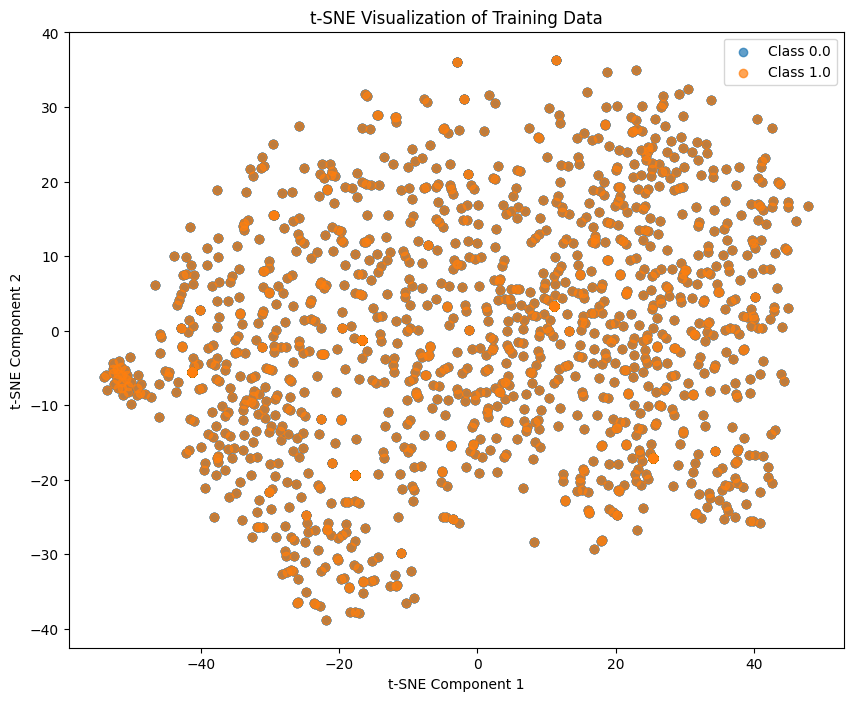

In [ ]:
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    indices = np.where(train_labels == label)
    plt.scatter(train_features_tsne[indices, 0], train_features_tsne[indices, 1], label=f"Class {label}", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:

knn = ManualKNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(train_features_tsne, train_y_int)


valid_predictions = knn.predict(valid_features_tsne)
valid_accuracy = manual_accuracy_score(valid_y_int, valid_predictions)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

test_predictions = knn.predict(test_features_tsne)
test_accuracy = manual_accuracy_score(test_y_int, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.5760
Test Accuracy: 0.6200


In [ ]:
def manual_precision_recall_f1(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    precisions = []
    recalls = []
    f1_scores = []
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    return np.mean(precisions), np.mean(recalls), np.mean(f1_scores)

precision, recall, f1 = manual_precision_recall_f1(test_y_int, test_predictions)
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Precision: 0.6525
Test Recall: 0.6200
Test F1-Score: 0.6244


In [ ]:

grid_search = ManualGridSearchCV(param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features_tsne, train_y_int)


best_knn = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


valid_predictions_tuned = best_knn.predict(valid_features_tsne)
test_predictions_tuned = best_knn.predict(test_features_tsne)
print(f"Tuned Validation Accuracy: {manual_accuracy_score(valid_y_int, valid_predictions_tuned):.4f}")
print(f"Tuned Test Accuracy: {manual_accuracy_score(test_y_int, test_predictions_tuned):.4f}")

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Tuned Validation Accuracy: 0.5760
Tuned Test Accuracy: 0.6400
